# Training pipeline

100%|██████████| 58/58 [00:14<00:00,  3.96it/s]


heart Data shape:  torch.Size([2204, 5000, 21]) Label shape:  torch.Size([2204, 5000, 1])
torch.Size([5000, 21]) torch.Size([5000, 1])


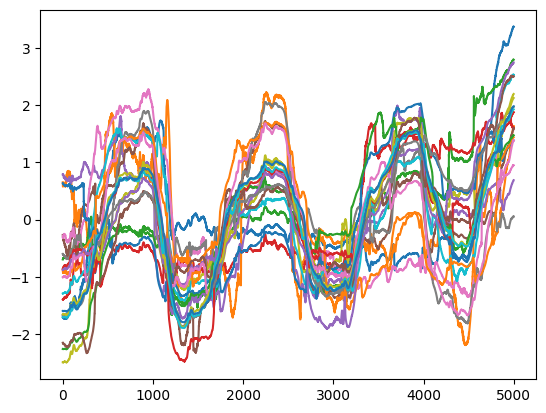

In [ ]:
from src.data.dataset import PulseDataset
import matplotlib.pyplot as plt
trainset = PulseDataset('/home/kyuan/RadarPulse/dataset/phase1_1212/train', 'heart')
data, label = trainset[0]
print(data.shape, label.shape)



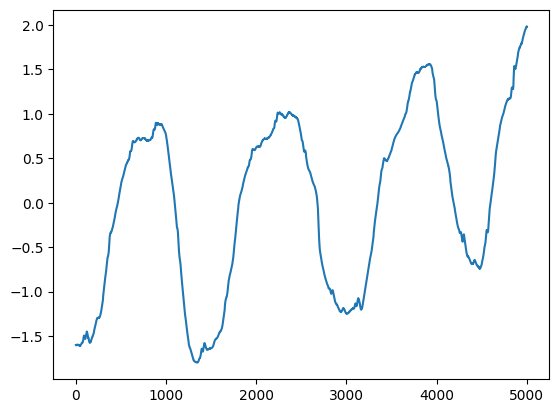

In [3]:
plt.plot(data[:,20])

In [1]:
from src.config.config_utils import load_config
config = load_config('src/config')

In [2]:
from src.data.datamodule import PulseDataModule
data_module = PulseDataModule(
    data_path=config.data.data_path,
    pulse_position=config.data.position,
    batch_size=config.training.batch_size,
    num_workers=config.training.num_workers
)
data_module.setup(stage='fit')

Setting up training dataset


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


wrist Data shape:  torch.Size([3072, 5000, 21]) Label shape:  torch.Size([3072, 5000, 1])
Setting up validation dataset


100%|██████████| 64/64 [00:11<00:00,  5.81it/s]


wrist Data shape:  torch.Size([576, 5000, 21]) Label shape:  torch.Size([576, 5000, 1])


In [3]:
from src.models.lightning_model import LitModel
for batch in data_module.train_dataloader():
    n_channels = batch[0].shape[2]
    break
model = LitModel(config, n_channels)

In [4]:
from pytorch_lightning.utilities.model_summary import ModelSummary
summary = ModelSummary(model, max_depth=2)
print(summary)

  | Name                 | Type              | Params
-----------------------------------------------------------
0 | model                | PulseDetectionNet | 854 K 
1 | model.encoder_blocks | ModuleList        | 228 K 
2 | model.lstm           | LSTM              | 198 K 
3 | model.decoder_blocks | ModuleList        | 424 K 
4 | model.final          | Sequential        | 3.2 K 
5 | criterion            | PulseLoss         | 0     
-----------------------------------------------------------
854 K     Trainable params
0         Non-trainable params
854 K     Total params
3.417     Total estimated model params size (MB)


In [8]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    max_epochs=config.training.max_epochs,
    accelerator='auto',
    devices='auto',
    logger=None,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kyuan/anaconda3/envs/torch310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
trainer.fit(model, data_module)

In [5]:
import torch
model = LitModel(config, n_channels)
# Then load the checkpoint
checkpoint = torch.load('/home/kyuan/RadarPulse/checkpoints/dataset/phase1_new_1214/wrist_kernel7-epoch=22-val_loss=0.21.ckpt', 
                       map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

(5000, 21) (5000, 1) (5000, 1)


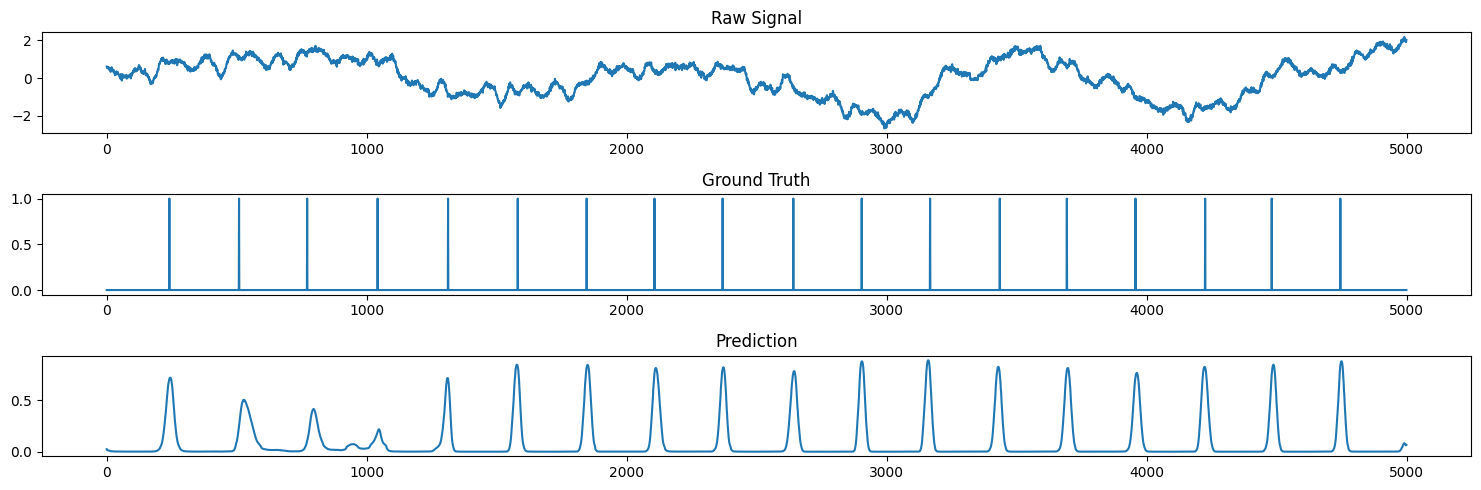

In [23]:
import matplotlib.pyplot as plt
import numpy as np
# Get validation batch and make predictions
for i, batch in enumerate(data_module.val_dataloader()):
    data = batch[0].to(model.device)  # Move to GPU if available
    label = batch[1].to(model.device)
    if i == 0:
        break

# with torch.no_grad():
pred = model(data)

# Convert to numpy for plotting
data = data[0].cpu().detach().numpy()  # First sample in batch
label = label[0].cpu().detach().numpy()
pred = pred[0].cpu().detach().numpy()

print(data.shape, label.shape, pred.shape)
# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(311)
plt.plot(data[:, 11])  # Plot magnitude of first channel
plt.title('Raw Signal')

plt.subplot(312)
plt.plot(label)
plt.title('Ground Truth')

plt.subplot(313)
plt.plot(pred)
plt.title('Prediction')
plt.tight_layout()
plt.show()

In [25]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(pred.reshape((-1,)), height=0.2, distance=250)
error = np.abs(peaks - np.where(label==1)[0])
error, error.mean()

(array([ 3, 18, 24,  5,  2,  4,  4,  5,  3,  3,  1,  7,  5,  3,  5,  2,  7,
         4]),
 5.833333333333333)